# PythonStatistics Project

In [1]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import scipy.stats as stats
import scipy.optimize as opt
%matplotlib inline

In [2]:
# Matplotlib style preference:
plt.rcParams["figure.figsize"] = (15, 8)

In [3]:
# sample generator
def data(N) :
    np.random.seed(154) # for reproducibility
    M=[0.,0.] # known expected values : E[x] = E[y] = 0
    Vx,Vy=1.0,4.0 # known variances : Var(x)=1 ; Var(y)=4
    r=np.random.uniform(0,1) # ’unknown’ correlation (KEEP IT BLIND - DO NOT PRINTOUT)
    Cxy=r * math.sqrt(Vx*Vy) # Covariance(x,y)
    COV = [ [ Vx , Cxy ], [Cxy, Vy ] ] # Covariance matrix
    XY = np.random.multivariate_normal(M, COV, size=N) # data generator XY = {(x_i,y_i)}
    return XY


In [4]:
r = data(5000)

### 1. Likelihood for our 2D Normal stat model :

Statistical modal for iid sample $\{X_i, Y_i\}$ :

## $ \mathcal{N(R,\rho) = \prod_{i=1}^{n} \frac{1}{2\pi \sqrt{det(C_{xy})}} e^\frac{\chi_i^2}{2} }$

After analytical developement we find the following $-\mathcal{log(L)}$ formula :

## $-\mathcal{log(L) = \frac{1}{2}\sum_{i=1}^{n} log(1-\rho^2) + \frac{1}{1-\rho^2}(x_i^2 + \frac{y_i^2}{4} - \rho x_i y_i)}$

1. Defining a func that calculates the $-\mathcal{log(L)}$ :

In [5]:
def _logL(param, r):
    '''
    r: the 2D variables vector  {(x_i,y_i)}
    param: the parameter of interest rho
    '''
    return np.sum(1/2*(np.log(1-param**2) + 1/(1-param**2) * (r[:,0]**2 + (r[:,1]**2)/4 - param*r[:,0]*r[:,1])))

2. Plotting $-\mathcal{log(L) = f(\rho)}$ :

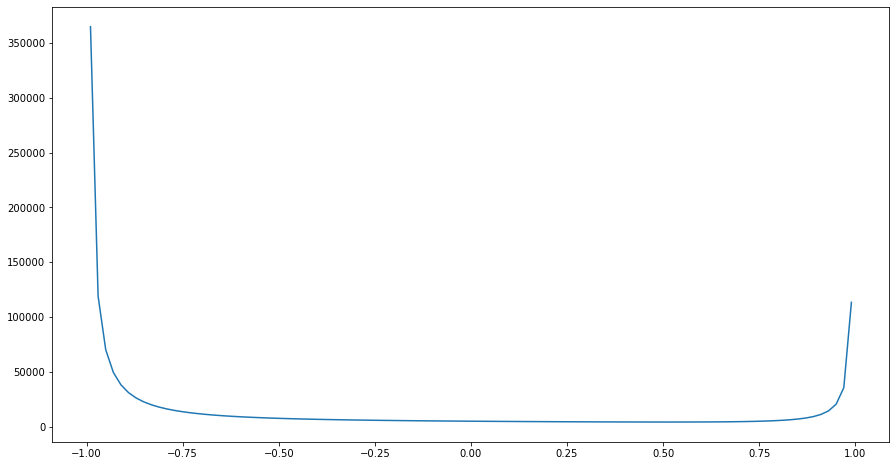

In [6]:
# computing -logL for values of p in [-0.9:0.9] and plotting the result
rhos = np.linspace(-0.99,0.99,101)
_logL_rho = []
for rho in rhos:
    _logL_rho.append(_logL(rho,r))
    
plt.plot(rhos,_logL_rho);

### 2. Minimizing the $-\mathcal{log(L)}$ using the minimization tools of the $Scipy$ module :

In [7]:
result = opt.minimize(_logL, x0=[0.1], args=r, method='Nelder-Mead')
result

 final_simplex: (array([[0.51304688],
       [0.513125  ]]), array([4198.78559983, 4198.78560898]))
           fun: 4198.785599827454
       message: 'Optimization terminated successfully.'
          nfev: 36
           nit: 18
        status: 0
       success: True
             x: array([0.51304688])

In [8]:
_logL_estimated_rho = result.fun
estimated_rho = result.x[0]

The estimated value of $\rho$ using the ML method is : $0.51$ <br/>
The corresponding minimal value of the $-\mathcal{log(L)}$ is : $4198.78$

### 3. Draw the function curve $\mathcal{∆logL(ρ) = logL(\hat{ρ}) − logL(ρ)}$ :

In [9]:
# choosing an interval for rho around the value estimated earlier
rhos = np.linspace(0.5,0.53,100)
_logL_rho = []
for rho in rhos:
    _logL_rho.append(_logL(rho,r))
    
delta_L = -_logL_estimated_rho + _logL_rho

plotting $\mathcal{∆logL(ρ)}$ :

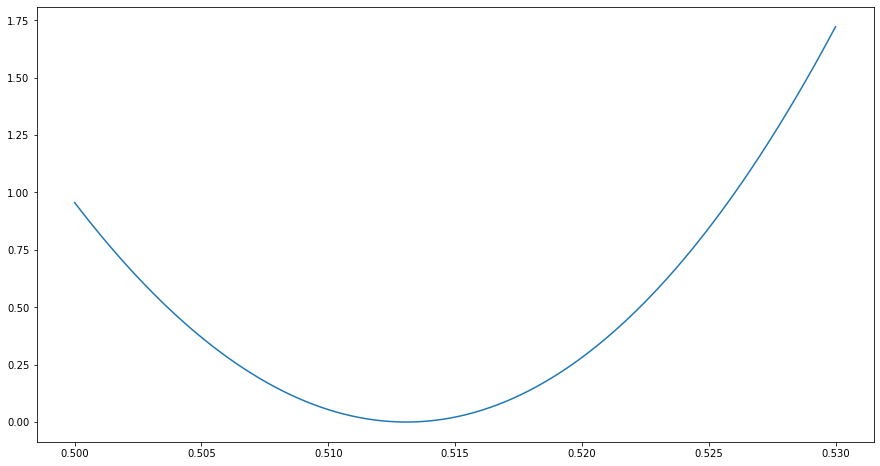

In [10]:
plt.figure(figsize=(15,8))
plt.plot(rhos, delta_L);

### 3-b. Finding the intercept between $\mathcal{∆logL(ρ)}$ and $y=\frac{1}{2}$ :

In [11]:
# indexes of rhos correspending to the intercepts

# np.sign : array describing the sign of the values (+1 if positive -1 if negative)
# np.diff : x(i+1) - x(i) : get a 'non 0 value' if there is a change of sign, and '0' otherwise
# np.argwhere : use it to get the index where the value is 'non 0'
rho_idx = np.argwhere(np.diff(np.sign(delta_L - np.full_like(rhos,0.5)))).flatten()

rhos[rho_idx]

array([0.50363636, 0.52212121])

Plotting again with the two intercepts: 

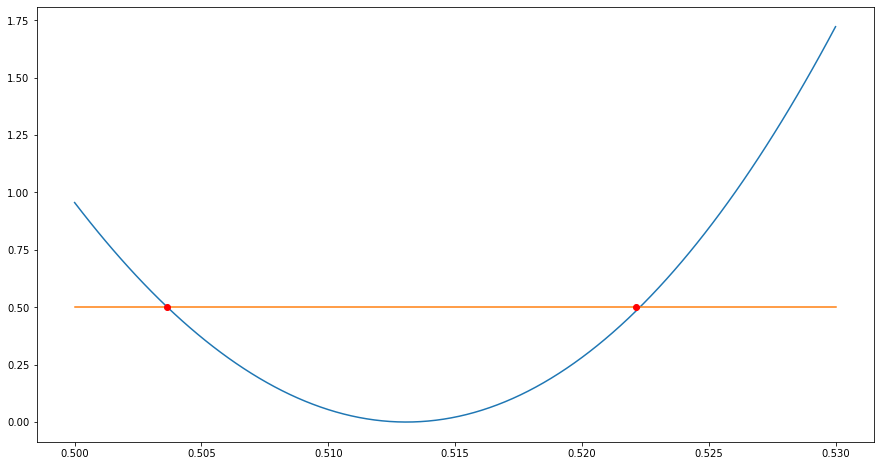

In [12]:
plt.figure(figsize=(15,8))
plt.plot(rhos, delta_L)
plt.plot(rhos,np.full_like(rhos,0.5)) # drawing a line at y=1/2
plt.plot(rhos[rho_idx], [.5,.5], 'ro');

### 3-c. Justify that we can define the uncertainty as $\sigma_\hat{\rho} = \frac{|\rho_+ - \rho_-|}{2}$ :


$\mathcal{∆logL(ρ)} = \frac{1}{2}$ is only valide for $\rho_\pm = \hat{\rho} \pm \sigma_\hat{\rho}$ <br />

1. $\rho_+ = \hat{\rho} + \sigma_\hat{\rho}$
1. $\rho_- = \hat{\rho} - \sigma_\hat{\rho}$

That leads us to : $|\rho_+ - \rho_-| = 2\sigma_\hat{\rho}$ <br />
and therefor : $\sigma_\hat{\rho} = \frac{|\rho_+ - \rho_-|}{2}$

In [13]:
std_rho_estimated = np.abs(rhos[rho_idx][1] - rhos[rho_idx][0]) / 2
std_rho_estimated

0.009242424242424219

### 4. Bi-dimensional representation of the sample with CL ellipse :

#### 4-a. Bi-dimensional representation of the sample $\{X_i, Y_i\}$ :

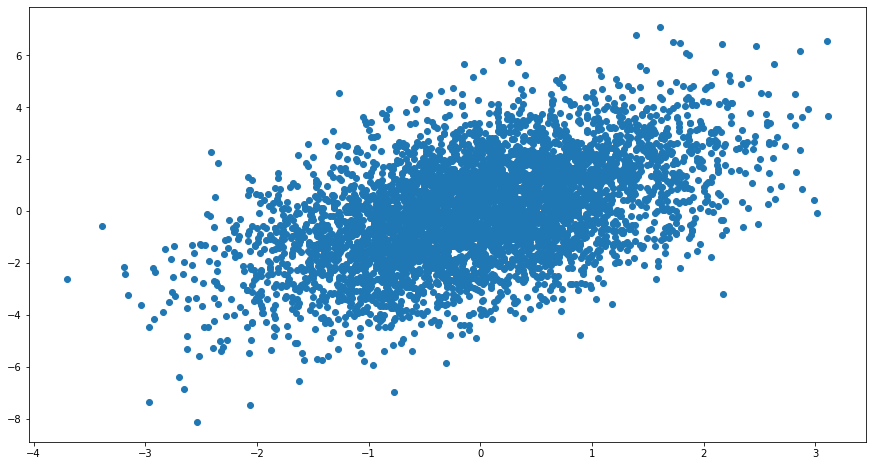

In [14]:
plt.scatter(r[:,0],r[:,1]);

#### 4-b. Confidence Level ellipse:

#### 4-b-i. Calculating ellipse parameters :

Creating a function that computes the Major and Minor axis radius of the confidence ellipse and it's Major Axis angle with the X-Axis :

In [15]:
def get_ellipse_params(rho, Vx, Vy):
    '''
    Compute the Major and Minor axis radius of the confidence ellipse and it's Major Axis angle with the X-Axis
    
    parameters
    ----------
    rho: the correlation parameter
    Vx : variance of X
    Vy : variance of Y
    
    return
    ------
    a : the major axis radius
    b : the minor axis radius
    angle: the major axis angle with the x-axis in radians
    '''
    # Covariance Matrix
    cov_xy = rho * np.sqrt(Vx*Vy) # Cov(X,Y)
    COV_m = np.array([[Vx, cov_xy],[cov_xy, Vy]])  # Covariance Matrix
    eigval, eigvec = np.linalg.eig(COV_m)  # Diagonalization
    # Ellipse Parameters
    a,b = np.sqrt(eigval) # Major and Minor axis radius
    angel = 1/2*np.arctan((2*rho*np.sqrt(Vx*Vy))/(Vx-Vy))  # Major Axis angle
    return a, b, angel

In [16]:
a,b,angle = get_ellipse_params(estimated_rho,1,4)
a,b,angle

(0.8262084860203092, 2.0778304881842575, -0.29997469048719394)

#### 4-b-ii. Determining the scale of the elipse: 

The size of the elipse containing 90% of the values (a 90% confidence intervale) can be found in the literature for Chi-square probabilities <br/>
reference : https://people.richland.edu/james/lecture/m170/tbl-chi.html <br/>

For a confidence interval of 90% we find that  $\mathcal{P(s<4.605) = 1-0.1=90\%}$ <br/>
which means that an elipse with s=4.605 will contain 90% of the points $\{Xi,Yi\}$

In [17]:
# s = 4.605  # P=90%
# s = 5.991  # P=95%
# s = 9.210  # P=99%
# s = 10.597  # P=99.5%
s = stats.chi2.ppf(0.9, 2) # ellipse size using scipy chi2 ppf

Drawing elipse :

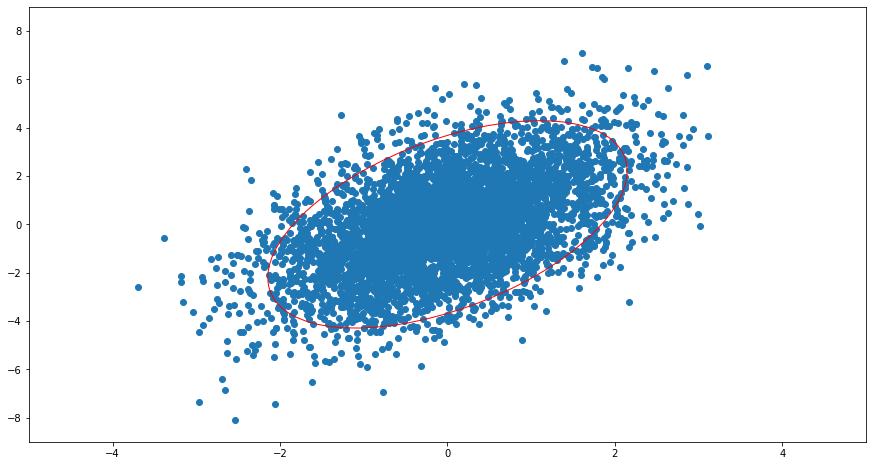

In [18]:
# Creating the ellipse object
e = Ellipse((0,0),2*a*math.sqrt(s), 2*b*math.sqrt(s), angle*180/np.pi, color='red')
e.set_fill(False)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot()

ax.scatter(r[:,0],r[:,1])  # plotting {Xi,Yi}

ax.add_patch(e)  # plotting the ellipses

ax.set_ylim(-9, 9)
ax.set_xlim(-5, 5)
plt.show()

#### For fun : Drawing the 90%, 95%, 99% and 99.5% confidence ellipses :

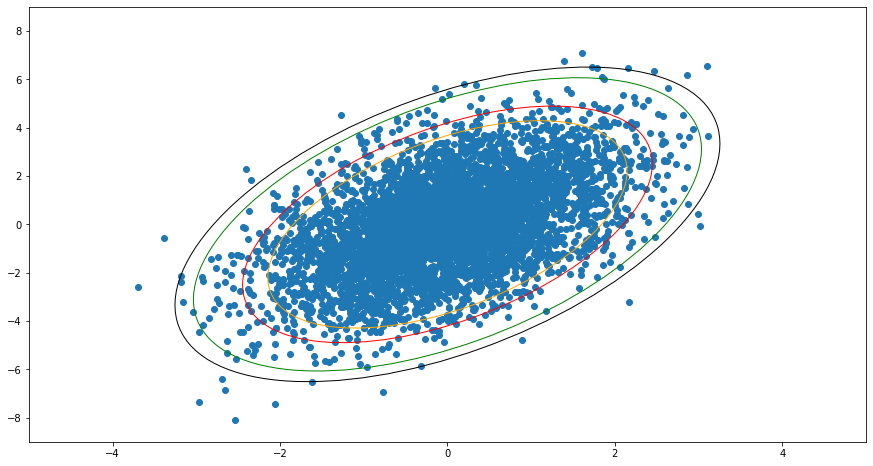

In [19]:
Ss = [4.605, 5.991, 9.210, 10.597]
es = [Ellipse((0,0),2*a*math.sqrt(s), 2*b*math.sqrt(s), angle*180/np.pi) for s in Ss]
colors = ['orange', 'red', 'green', 'black']

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot()
ax.scatter(r[:,0],r[:,1], vmin=-10)  # plotting {Xi,Yi}
for i in range(len(es)):   # plotting the ellipses
    es[i].set_fill(False)
    es[i].set_color(colors[i])
    ax.add_patch(es[i])
ax.set_ylim(-9, 9)
ax.set_xlim(-5, 5)
plt.show()

### 5. Coverage study

#### 5-a. Computing the ratio $\hat{p}_{90} = \frac{N_{90}}{N}$ :

Creating a function that counts the ratio of points inside an ellipse caracterized with $a, b, angle$ :

In [20]:
def count_pts_ratio_in_ellip(points:[], a:float, b:float, angle:float, percentil:float, df:int=2):
    '''
    counts the ratio of points inside an ellipse and evaluates the statistical error associated to it.
    
    parameters
    ----------
    points : array of {Xi,Yi}
    a : the major axis radius
    b : the minor axis radius
    angle : the angle of the ellipse in radians
    percentil : the percentile point of the chi-2 ppf (the confidence level)
    df: degree of freedom (default = 2)
    
    return
    ------
    ratio : ratio of points inside the ellipse
    stat_err : the statistical error on the ratio following a binomial law
    '''
    
    # ellipse size
    s = stats.chi2.ppf(percentil, df)
    
    # new points coordinates in the ellipse axis basis ie: rotating the points
    rot_m = np.array([[np.cos(angle), np.sin(angle)],[-np.sin(angle), np.cos(angle)]])
    points_new = []
    for i in range(len(points[:,0])):
        points_new.append(np.dot(rot_m,points[i,:]))
    points_new = np.array(points_new)
    
    # counting points inside the ellipse
    val = (points_new[:,0]/a)**2 + (points_new[:,1]/b)**2 # left side of ellipse equation
    s_vec = np.full_like(val, s) # creating a vector of s for vectorized computation with numpy
    inside = val <= s_vec # a mask determinig wether the points are in
    N = points.shape[0] # number of points {Xi,Yi}
    ratio = inside.sum()/N
    
    # evaluating the statistical error
    stat_err = math.sqrt(ratio*(1-ratio)/len(points[:,0]))
    return ratio, stat_err

Calculating $\hat{p}_{90}$ and it's statistical error:

In [21]:
p_90, p_90_stat_err = count_pts_ratio_in_ellip(r, a, b, angle, 0.9)
p_90

0.9008

#### 5-b. Evaluating the statistical error

In [22]:
# already evaluated in the func "count_pts_ratio_in_ellip"
p_90_stat_err

0.004227513690102019

### 6. Systematical error :

#### 6.a Evaluating the systematical error

In [23]:
# an array of rho values that are between one std of estimated rho
rho_sample = np.linspace(rhos[rho_idx][0],rhos[rho_idx][1], 10) #rhos[rho_idx] are the two extreme values [rho_est +- std_rho_est]

# calculating different ellipses parameters for these values
As, Bs, Angles = [], [], []
for rho in rho_sample:
    _a,_b,_angle = get_ellipse_params(rho, 1, 4)
    As.append(_a)
    Bs.append(_b)
    Angles.append(_angle)
    
# computing different ratios for different ellipses found above
ratios_sample = []
for i in range(len(As)):
    ratio, err = count_pts_ratio_in_ellip(r, As[i], Bs[i], Angles[i], .9)
    ratios_sample.append(ratio)
ratios_array = np.array(ratios_sample)

In [24]:
# the estimated syst error of ratio p_90 :
p_90_syst_err = ratios_array.std()
p_90_syst_err

0.0006144916598295013

The syst error is negligable with respect to the stat error, there is a factor 7 between them :

In [25]:
p_90_stat_err / p_90_syst_err

6.879692543386184

#### 6.b Comparing the estimated value with the expected one :

In [26]:
[p_90 - p_90_stat_err, p_90 + p_90_stat_err]

[0.896572486309898, 0.905027513690102]

the expected value of p_90 should be 0.9 and it is indeed inside the interval of the estimated p_90 +- error

### 7. Repeat study for different CL ellipses:

#### 7.a Estimating p values :

In [27]:
CLs = np.linspace(.005,.995,34) # confidence level from 0.5% to 99.5% with a step of 3%
P_i = []
for cl in CLs:
    P_i.append(count_pts_ratio_in_ellip(r,a,b,angle,cl))
P_i = np.array(P_i) # array of estimated rhos and their respective statistical errors

#### 7-b. Plot the differences $∆p = \hat{p}_{CL} − CL$ and their error bars:

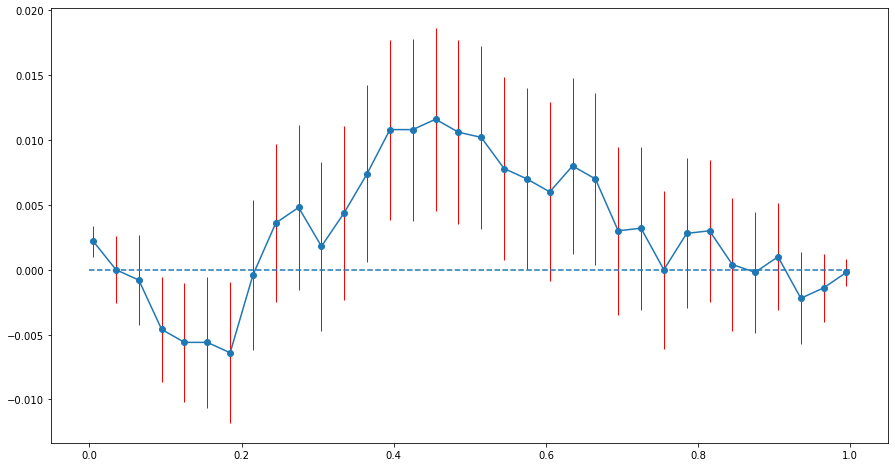

In [28]:
delta_p_cl = P_i[:,0] - CLs # ∆p
p_errs = P_i[:,1]  # Ps stat errors
plt.errorbar(CLs, delta_p_cl, yerr=p_errs, elinewidth= 1, ecolor='red', marker='o')
plt.hlines(0,0,1, linestyles='--');

We notice a small fluctuation arround the true value except around $\hat{p}_{50}$ where there is a maximum of error and also the estimated value is relativly far from the true value even when taking into account the statistical errors. <br/> 
The maximum of error around $\hat{p}_{50}$ was predictable from the binomial law, we can see that more clearly in the plot bellow :

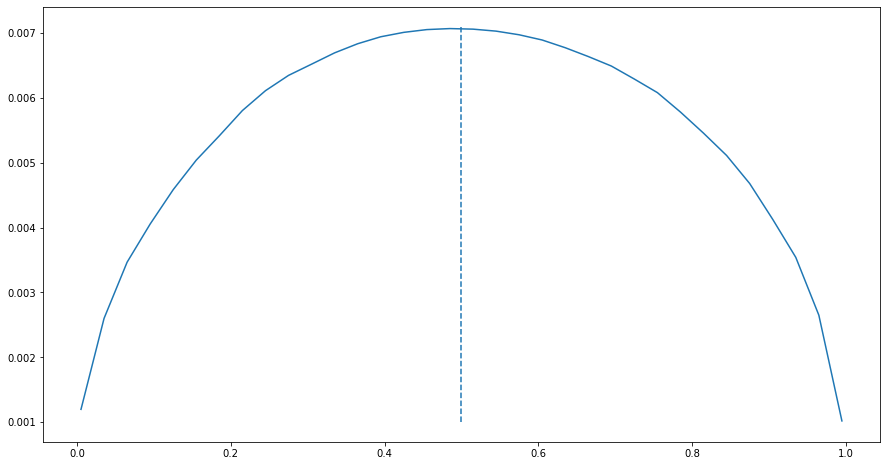

In [29]:
plt.plot(CLs,P_i[:,1])
plt.vlines(0.5,0.001,0.0071, linestyles='--');